1. LIBRERÍAS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp


2. CONFIGURACIÒN MPS MAC

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Dispositivo:", device)

Dispositivo: mps


3. DIRECTORIOS Y TRANSFORMACIONES

In [ ]:
data_dir = "./Training_dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Tamaño recomendado para ResNet50
    transforms.RandomHorizontalFlip(),     
    transforms.RandomRotation(15),         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización estándar para ResNet50
                         std=[0.229, 0.224, 0.225])
])

4. CARGA DE DATOS

In [4]:
# Cargar datasets con las transformaciones adaptadas
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Crear DataLoaders para entrenamiento, validación y prueba
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Obtener los nombres de las clases
class_names = train_dataset.classes

# Información básica de los datos cargados
print("Clases detectadas:", class_names)
print(f"Número de clases: {len(class_names)}")
print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del dataset de validación: {len(val_dataset)}")
print(f"Tamaño del dataset de prueba: {len(test_dataset)}")


Clases detectadas: ['Asphalt', 'Badly_seg_ditches', 'Barrer', 'Border', 'Ditches', 'Phy_obstructions']
Número de clases: 6
Tamaño del dataset de entrenamiento: 21000
Tamaño del dataset de validación: 4500
Tamaño del dataset de prueba: 4500


5. CARGAR ResNet50

In [5]:
# Cargar ResNet50 con pesos preentrenados
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
resnet = resnet.to(device)

# Definir optimizador y función de pérdida
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Configurar los schedulers
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
early_stopping_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10) 

# Mostrar la tasa de aprendizaje actual
print("Learning rate actual:", optimizer.param_groups[0]['lr'])

Learning rate actual: 0.001


6. ENTRENAMIENTO Y VALIDACIÓN

In [6]:
train_loss, val_loss, train_acc, val_acc = [], [], [], []
total_time_mps = 0
start_time = time.time()

for epoch in range(100):
    tqdm.write(f"\nEpoch {epoch + 1}/100")
    resnet.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Entrenando Epoca {epoch + 1}", unit="lote", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward y cálculo de la pérdida
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix({
            'Train Loss': f"{running_loss / (total / labels.size(0)):.4f}",
            'accurate': f"{correct / total:.4f}"
        })

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total

    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # Validación
    resnet.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = running_loss / len(val_loader)
    epoch_val_acc = correct / total

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    # Scheduler de reducción de learning rate en plateau
    early_stopping_scheduler.step(epoch_val_loss)

    tqdm.write(f"Epoca {epoch + 1}/{100} -> "
               f"Train Loss: {epoch_train_loss:.4f}, "
               f"Val Loss: {epoch_val_loss:.4f}, "
               f"accurate: {epoch_train_acc:.4f}, "
               f"val_accurate: {epoch_val_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")


Epoch 1/100


Epoca 1/100 -> Train Loss: 0.4700, Val Loss: 0.2820, accurate: 0.8513, val_accurate: 0.9151

Epoch 2/100


Epoca 2/100 -> Train Loss: 0.2459, Val Loss: 0.3179, accurate: 0.9217, val_accurate: 0.8967

Epoch 3/100


Epoca 3/100 -> Train Loss: 0.2210, Val Loss: 0.1889, accurate: 0.9330, val_accurate: 0.9422

Epoch 4/100


Epoca 4/100 -> Train Loss: 0.1726, Val Loss: 0.1630, accurate: 0.9480, val_accurate: 0.9513

Epoch 5/100


Epoca 5/100 -> Train Loss: 0.1457, Val Loss: 0.1713, accurate: 0.9571, val_accurate: 0.9496

Epoch 6/100


Epoca 6/100 -> Train Loss: 0.1413, Val Loss: 0.1457, accurate: 0.9569, val_accurate: 0.9616

Epoch 7/100


Epoca 7/100 -> Train Loss: 0.1094, Val Loss: 0.0856, accurate: 0.9647, val_accurate: 0.9736

Epoch 8/100


Epoca 8/100 -> Train Loss: 0.1051, Val Loss: 0.1181, accurate: 0.9683, val_accurate: 0.9651

Epoch 9/100


Epoca 9/100 -> Train Loss: 0.0965, Val Loss: 1.1157, accurate: 0.9704, val_accurate: 0.7556

Epoch 10/100


Epoca 10/100 -> Train Loss: 0.0948, Val Loss: 0.1429, accurate: 0.9724, val_accurate: 0.9591

Epoch 11/100


Epoca 11/100 -> Train Loss: 0.0783, Val Loss: 0.0650, accurate: 0.9761, val_accurate: 0.9820

Epoch 12/100


Epoca 12/100 -> Train Loss: 0.0731, Val Loss: 0.1000, accurate: 0.9789, val_accurate: 0.9704

Epoch 13/100


Epoca 13/100 -> Train Loss: 0.0822, Val Loss: 0.1181, accurate: 0.9754, val_accurate: 0.9649

Epoch 14/100


Epoca 14/100 -> Train Loss: 0.0662, Val Loss: 0.1279, accurate: 0.9793, val_accurate: 0.9596

Epoch 15/100


Epoca 15/100 -> Train Loss: 0.0698, Val Loss: 0.0643, accurate: 0.9795, val_accurate: 0.9836

Epoch 16/100


Epoca 16/100 -> Train Loss: 0.0568, Val Loss: 0.0910, accurate: 0.9830, val_accurate: 0.9713

Epoch 17/100


Epoca 17/100 -> Train Loss: 0.0523, Val Loss: 0.0890, accurate: 0.9846, val_accurate: 0.9780

Epoch 18/100


Epoca 18/100 -> Train Loss: 0.0530, Val Loss: 0.0918, accurate: 0.9829, val_accurate: 0.9758

Epoch 19/100


Epoca 19/100 -> Train Loss: 0.0464, Val Loss: 0.1272, accurate: 0.9853, val_accurate: 0.9602

Epoch 20/100


Epoca 20/100 -> Train Loss: 0.0536, Val Loss: 0.0721, accurate: 0.9840, val_accurate: 0.9829

Epoch 21/100


Epoca 21/100 -> Train Loss: 0.0392, Val Loss: 0.0568, accurate: 0.9875, val_accurate: 0.9844

Epoch 22/100


Epoca 22/100 -> Train Loss: 0.0405, Val Loss: 0.0596, accurate: 0.9877, val_accurate: 0.9858

Epoch 23/100


Epoca 23/100 -> Train Loss: 0.0342, Val Loss: 0.1719, accurate: 0.9900, val_accurate: 0.9607

Epoch 24/100


Epoca 24/100 -> Train Loss: 0.0446, Val Loss: 0.0754, accurate: 0.9855, val_accurate: 0.9778

Epoch 25/100


Epoca 25/100 -> Train Loss: 0.0373, Val Loss: 0.0542, accurate: 0.9892, val_accurate: 0.9858

Epoch 26/100


Epoca 26/100 -> Train Loss: 0.0323, Val Loss: 0.0582, accurate: 0.9909, val_accurate: 0.9862

Epoch 27/100


Epoca 27/100 -> Train Loss: 0.0395, Val Loss: 0.0602, accurate: 0.9880, val_accurate: 0.9851

Epoch 28/100


Epoca 28/100 -> Train Loss: 0.0279, Val Loss: 0.0449, accurate: 0.9911, val_accurate: 0.9876

Epoch 29/100


Epoca 29/100 -> Train Loss: 0.0301, Val Loss: 0.1164, accurate: 0.9913, val_accurate: 0.9682

Epoch 30/100


Epoca 30/100 -> Train Loss: 0.0290, Val Loss: 0.0691, accurate: 0.9908, val_accurate: 0.9809

Epoch 31/100


Epoca 31/100 -> Train Loss: 0.0293, Val Loss: 0.0569, accurate: 0.9911, val_accurate: 0.9862

Epoch 32/100


Epoca 32/100 -> Train Loss: 0.0348, Val Loss: 0.0689, accurate: 0.9895, val_accurate: 0.9851

Epoch 33/100


Epoca 33/100 -> Train Loss: 0.0255, Val Loss: 0.0548, accurate: 0.9920, val_accurate: 0.9853

Epoch 34/100


Epoca 34/100 -> Train Loss: 0.0278, Val Loss: 0.0491, accurate: 0.9917, val_accurate: 0.9882

Epoch 35/100


Epoca 35/100 -> Train Loss: 0.0166, Val Loss: 0.0606, accurate: 0.9952, val_accurate: 0.9878

Epoch 36/100


Epoca 36/100 -> Train Loss: 0.0294, Val Loss: 0.0701, accurate: 0.9910, val_accurate: 0.9824

Epoch 37/100


Epoca 37/100 -> Train Loss: 0.0211, Val Loss: 0.0394, accurate: 0.9931, val_accurate: 0.9907

Epoch 38/100


Epoca 38/100 -> Train Loss: 0.0255, Val Loss: 0.0685, accurate: 0.9919, val_accurate: 0.9858

Epoch 39/100


Epoca 39/100 -> Train Loss: 0.0219, Val Loss: 0.0555, accurate: 0.9934, val_accurate: 0.9862

Epoch 40/100


Epoca 40/100 -> Train Loss: 0.0232, Val Loss: 0.0592, accurate: 0.9926, val_accurate: 0.9867

Epoch 41/100


Epoca 41/100 -> Train Loss: 0.0195, Val Loss: 0.0467, accurate: 0.9934, val_accurate: 0.9891

Epoch 42/100


Epoca 42/100 -> Train Loss: 0.0195, Val Loss: 0.0434, accurate: 0.9936, val_accurate: 0.9882

Epoch 43/100


Epoca 43/100 -> Train Loss: 0.0193, Val Loss: 0.0491, accurate: 0.9937, val_accurate: 0.9887

Epoch 44/100


Epoca 44/100 -> Train Loss: 0.0204, Val Loss: 0.0486, accurate: 0.9930, val_accurate: 0.9913

Epoch 45/100


Epoca 45/100 -> Train Loss: 0.0197, Val Loss: 0.0475, accurate: 0.9940, val_accurate: 0.9880

Epoch 46/100


Epoca 46/100 -> Train Loss: 0.0141, Val Loss: 0.0705, accurate: 0.9953, val_accurate: 0.9853

Epoch 47/100


Epoca 47/100 -> Train Loss: 0.0195, Val Loss: 0.0408, accurate: 0.9936, val_accurate: 0.9898

Epoch 48/100


Epoca 48/100 -> Train Loss: 0.0140, Val Loss: 0.0534, accurate: 0.9953, val_accurate: 0.9896

Epoch 49/100


Epoca 49/100 -> Train Loss: 0.0066, Val Loss: 0.0483, accurate: 0.9980, val_accurate: 0.9920

Epoch 50/100


Epoca 50/100 -> Train Loss: 0.0046, Val Loss: 0.0367, accurate: 0.9988, val_accurate: 0.9924

Epoch 51/100


Epoca 51/100 -> Train Loss: 0.0053, Val Loss: 0.0420, accurate: 0.9984, val_accurate: 0.9929

Epoch 52/100


Epoca 52/100 -> Train Loss: 0.0054, Val Loss: 0.0420, accurate: 0.9982, val_accurate: 0.9924

Epoch 53/100


Epoca 53/100 -> Train Loss: 0.0044, Val Loss: 0.0445, accurate: 0.9985, val_accurate: 0.9913

Epoch 54/100


Epoca 54/100 -> Train Loss: 0.0032, Val Loss: 0.0472, accurate: 0.9991, val_accurate: 0.9904

Epoch 55/100


Epoca 55/100 -> Train Loss: 0.0062, Val Loss: 0.0622, accurate: 0.9979, val_accurate: 0.9862

Epoch 56/100


Epoca 56/100 -> Train Loss: 0.0053, Val Loss: 0.0571, accurate: 0.9980, val_accurate: 0.9902

Epoch 57/100


Epoca 57/100 -> Train Loss: 0.0082, Val Loss: 0.0474, accurate: 0.9980, val_accurate: 0.9922

Epoch 58/100


Epoca 58/100 -> Train Loss: 0.0021, Val Loss: 0.0362, accurate: 0.9994, val_accurate: 0.9938

Epoch 59/100


Epoca 59/100 -> Train Loss: 0.0061, Val Loss: 0.0421, accurate: 0.9981, val_accurate: 0.9927

Epoch 60/100


Epoca 60/100 -> Train Loss: 0.0040, Val Loss: 0.0394, accurate: 0.9988, val_accurate: 0.9947

Epoch 61/100


Epoca 61/100 -> Train Loss: 0.0065, Val Loss: 0.0428, accurate: 0.9977, val_accurate: 0.9924

Epoch 62/100


Epoca 62/100 -> Train Loss: 0.0055, Val Loss: 0.0369, accurate: 0.9981, val_accurate: 0.9931

Epoch 63/100


Epoca 63/100 -> Train Loss: 0.0042, Val Loss: 0.0537, accurate: 0.9989, val_accurate: 0.9918

Epoch 64/100


Epoca 64/100 -> Train Loss: 0.0059, Val Loss: 0.0403, accurate: 0.9979, val_accurate: 0.9913

Epoch 65/100


Epoca 65/100 -> Train Loss: 0.0043, Val Loss: 0.0542, accurate: 0.9985, val_accurate: 0.9913

Epoch 66/100


Epoca 66/100 -> Train Loss: 0.0057, Val Loss: 0.0467, accurate: 0.9984, val_accurate: 0.9909

Epoch 67/100


Epoca 67/100 -> Train Loss: 0.0070, Val Loss: 0.0503, accurate: 0.9980, val_accurate: 0.9902

Epoch 68/100


Epoca 68/100 -> Train Loss: 0.0029, Val Loss: 0.0375, accurate: 0.9990, val_accurate: 0.9938

Epoch 69/100


Epoca 69/100 -> Train Loss: 0.0019, Val Loss: 0.0582, accurate: 0.9994, val_accurate: 0.9916

Epoch 70/100


Epoca 70/100 -> Train Loss: 0.0008, Val Loss: 0.0401, accurate: 0.9997, val_accurate: 0.9933

Epoch 71/100


Epoca 71/100 -> Train Loss: 0.0012, Val Loss: 0.0375, accurate: 0.9997, val_accurate: 0.9940

Epoch 72/100


Epoca 72/100 -> Train Loss: 0.0015, Val Loss: 0.0491, accurate: 0.9996, val_accurate: 0.9936

Epoch 73/100


Epoca 73/100 -> Train Loss: 0.0020, Val Loss: 0.0361, accurate: 0.9994, val_accurate: 0.9927

Epoch 74/100


Epoca 74/100 -> Train Loss: 0.0013, Val Loss: 0.0552, accurate: 0.9994, val_accurate: 0.9922

Epoch 75/100


Epoca 75/100 -> Train Loss: 0.0020, Val Loss: 0.0432, accurate: 0.9993, val_accurate: 0.9929

Epoch 76/100


Epoca 76/100 -> Train Loss: 0.0023, Val Loss: 0.0418, accurate: 0.9996, val_accurate: 0.9931

Epoch 77/100


Epoca 77/100 -> Train Loss: 0.0012, Val Loss: 0.0390, accurate: 0.9996, val_accurate: 0.9931

Epoch 78/100


Epoca 78/100 -> Train Loss: 0.0012, Val Loss: 0.0416, accurate: 0.9998, val_accurate: 0.9938

Epoch 79/100


Epoca 79/100 -> Train Loss: 0.0004, Val Loss: 0.0375, accurate: 1.0000, val_accurate: 0.9942

Epoch 80/100


Epoca 80/100 -> Train Loss: 0.0011, Val Loss: 0.0392, accurate: 0.9996, val_accurate: 0.9936

Epoch 81/100


Epoca 81/100 -> Train Loss: 0.0013, Val Loss: 0.0427, accurate: 0.9997, val_accurate: 0.9938

Epoch 82/100


Epoca 82/100 -> Train Loss: 0.0012, Val Loss: 0.0433, accurate: 0.9995, val_accurate: 0.9940

Epoch 83/100


Epoca 83/100 -> Train Loss: 0.0002, Val Loss: 0.0387, accurate: 1.0000, val_accurate: 0.9940

Epoch 84/100


Epoca 84/100 -> Train Loss: 0.0029, Val Loss: 0.0363, accurate: 0.9993, val_accurate: 0.9940

Epoch 85/100


Epoca 85/100 -> Train Loss: 0.0015, Val Loss: 0.0317, accurate: 0.9997, val_accurate: 0.9944

Epoch 86/100


Epoca 86/100 -> Train Loss: 0.0002, Val Loss: 0.0434, accurate: 1.0000, val_accurate: 0.9924

Epoch 87/100


Epoca 87/100 -> Train Loss: 0.0002, Val Loss: 0.0384, accurate: 1.0000, val_accurate: 0.9936

Epoch 88/100


Epoca 88/100 -> Train Loss: 0.0002, Val Loss: 0.0410, accurate: 1.0000, val_accurate: 0.9936

Epoch 89/100


Epoca 89/100 -> Train Loss: 0.0003, Val Loss: 0.0437, accurate: 1.0000, val_accurate: 0.9931

Epoch 90/100


Epoca 90/100 -> Train Loss: 0.0001, Val Loss: 0.0440, accurate: 1.0000, val_accurate: 0.9936

Epoch 91/100


Epoca 91/100 -> Train Loss: 0.0003, Val Loss: 0.0544, accurate: 0.9999, val_accurate: 0.9929

Epoch 92/100


Epoca 92/100 -> Train Loss: 0.0004, Val Loss: 0.0507, accurate: 0.9998, val_accurate: 0.9938

Epoch 93/100


Epoca 93/100 -> Train Loss: 0.0001, Val Loss: 0.0404, accurate: 1.0000, val_accurate: 0.9942

Epoch 94/100


Epoca 94/100 -> Train Loss: 0.0010, Val Loss: 0.0541, accurate: 0.9997, val_accurate: 0.9927

Epoch 95/100


Epoca 95/100 -> Train Loss: 0.0010, Val Loss: 0.0515, accurate: 0.9996, val_accurate: 0.9924

Epoch 96/100


Epoca 96/100 -> Train Loss: 0.0008, Val Loss: 0.0461, accurate: 0.9998, val_accurate: 0.9933

Epoch 97/100


Epoca 97/100 -> Train Loss: 0.0006, Val Loss: 0.0471, accurate: 0.9999, val_accurate: 0.9940

Epoch 98/100


Epoca 98/100 -> Train Loss: 0.0002, Val Loss: 0.0515, accurate: 0.9999, val_accurate: 0.9920

Epoch 99/100


Epoca 99/100 -> Train Loss: 0.0001, Val Loss: 0.0403, accurate: 1.0000, val_accurate: 0.9936

Epoch 100/100


Epoca 100/100 -> Train Loss: 0.0001, Val Loss: 0.0415, accurate: 1.0000, val_accurate: 0.9933
Tiempo total de entrenamiento: 37685.95 segundos


7. GUARDAR EL MODELO

In [7]:
torch.save(resnet.state_dict(), "Models/ResNet50_model.pth")

8. EVALUACIÓN EN EL CONJUNTO DE PRUEBA

In [8]:
# Crear directorio para guardar resultados
os.makedirs("ResNet50", exist_ok=True)
resnet.eval()
y_true, y_pred = [], []
embeddings = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Extraer embeddings (características) usando la capa promedio antes de la capa fully connected
        features = resnet.avgpool(resnet.layer4(resnet.layer3(resnet.layer2(resnet.layer1(resnet.conv1(images))))))
        embeddings.append(features.view(features.size(0), -1).cpu().numpy())
        
        # Forward para obtener predicciones
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Concatenar embeddings y guardar métricas
embeddings = np.concatenate(embeddings)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel("ResNet50/Metricas_ResNet50.xlsx")

9. MATRIZ DE CONFUSIÓN

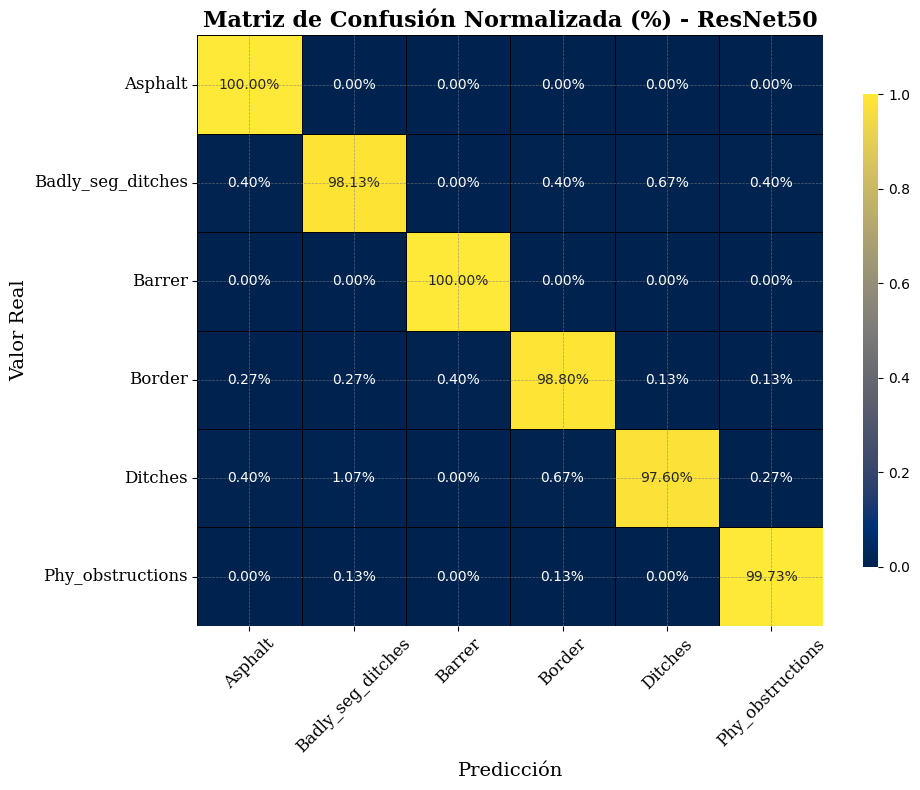

Matriz de confusión guardada en 'ResNet50'.


In [9]:
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

os.makedirs("ResNet50", exist_ok=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_norm, 
    annot=True, 
    fmt='.2%', 
    cmap='cividis',  
    xticklabels=class_names, 
    yticklabels=class_names,
    linewidths=0.5,        
    linecolor='black',     
    cbar_kws={'aspect': 30, 'shrink': 0.8}  
)

plt.title('Matriz de Confusión Normalizada (%) - ResNet50', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Predicción', fontsize=14, family='serif')
plt.ylabel('Valor Real', fontsize=14, family='serif')
plt.xticks(rotation=45, fontsize=12, family='serif')
plt.yticks(rotation=0, fontsize=12, family='serif')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.savefig("ResNet50/Matriz_confusion.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("ResNet50/Matriz_confusion.png", dpi=300, bbox_inches='tight')
plt.show()

print("Matriz de confusión guardada en 'ResNet50'.")



10. GRAFICAR MÉTRICAS

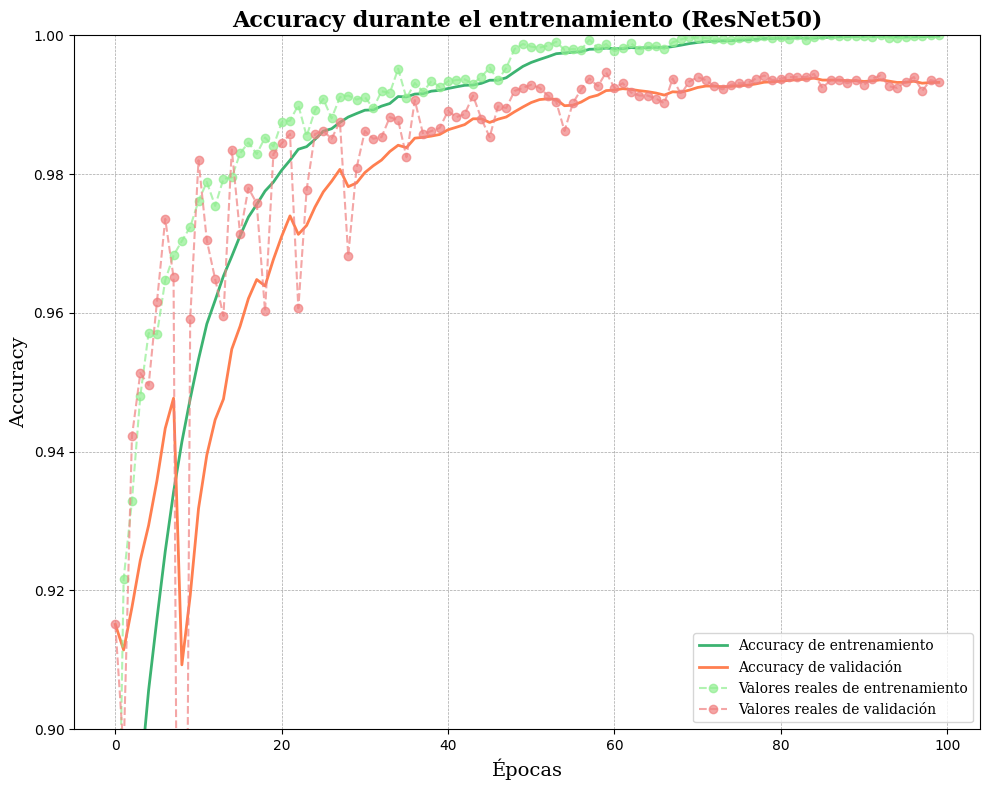

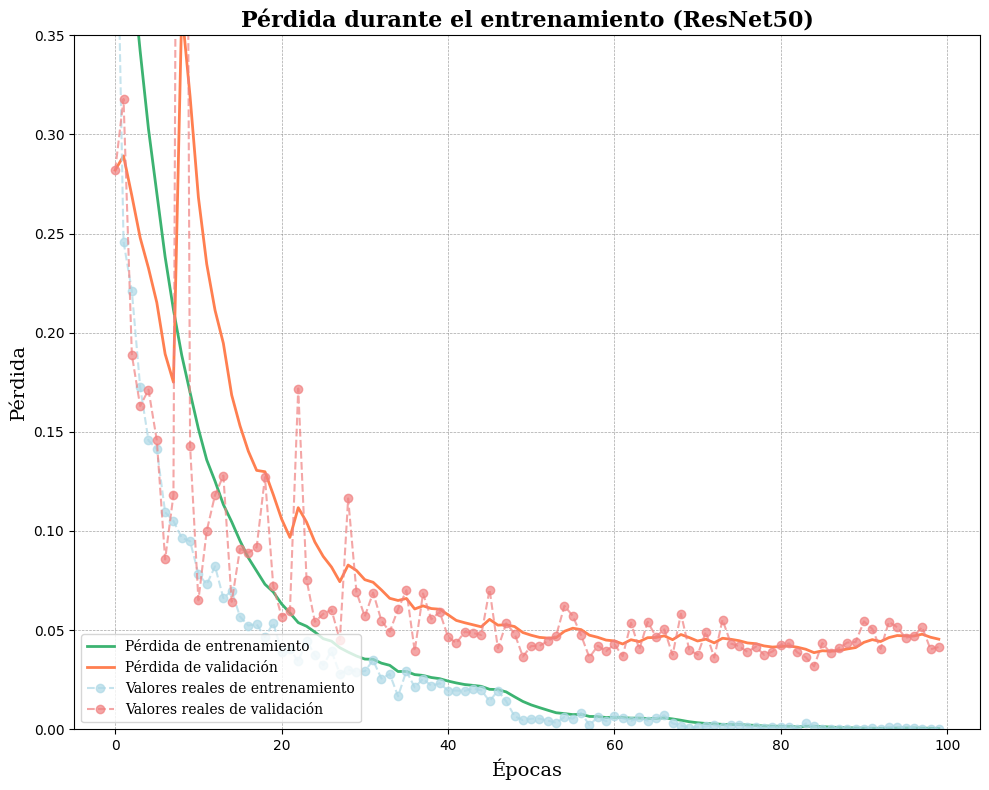

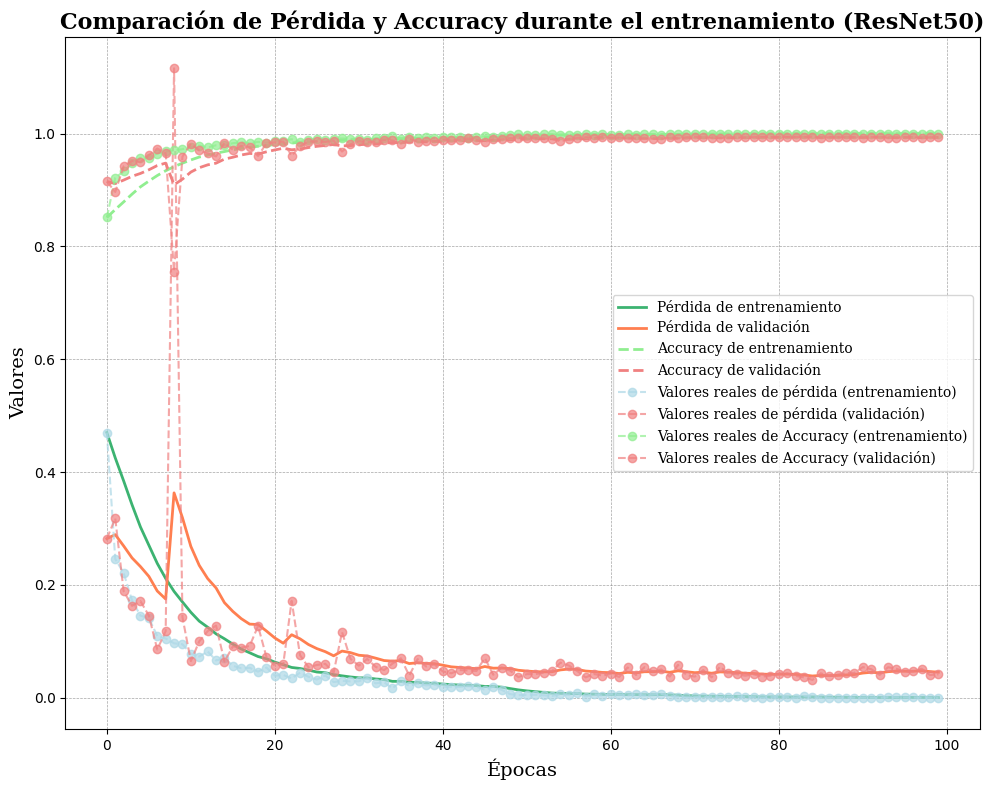

In [10]:
def suavizar(valores, peso=0.8):
    smoothed = []
    ultimo = valores[0]
    for punto in valores:
        smoothed_val = ultimo * peso + (1 - peso) * punto
        smoothed.append(smoothed_val)
        ultimo = smoothed_val
    return smoothed

train_acc_smooth = suavizar(train_acc)
val_acc_smooth = suavizar(val_acc)
train_loss_smooth = suavizar(train_loss)
val_loss_smooth = suavizar(val_loss)

os.makedirs("ResNet50", exist_ok=True)

plt.figure(figsize=(10, 8))
plt.plot(train_acc_smooth, label='Accuracy de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_acc_smooth, label='Accuracy de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_acc, 'o--', alpha=0.7, color='lightgreen', label='Valores reales de entrenamiento')
plt.plot(val_acc, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de validación')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Accuracy', fontsize=14, family='serif')
plt.title('Accuracy durante el entrenamiento (ResNet50)', fontsize=16, fontweight='bold', family='serif')
plt.ylim([0.9, 1.0])
plt.legend(loc='lower right', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("ResNet50/Accuracy_ResNet50.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("ResNet50/Accuracy_ResNet50.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(train_loss_smooth, label='Pérdida de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_loss_smooth, label='Pérdida de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_loss, 'o--', alpha=0.7, color='lightblue', label='Valores reales de entrenamiento')
plt.plot(val_loss, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de validación')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Pérdida', fontsize=14, family='serif')
plt.title('Pérdida durante el entrenamiento (ResNet50)', fontsize=16, fontweight='bold', family='serif')
plt.ylim([0, 0.35])
plt.legend(loc='lower left', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("ResNet50/Perdida_ResNet50.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("ResNet50/Perdida_ResNet50.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(train_loss_smooth, label='Pérdida de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_loss_smooth, label='Pérdida de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_acc_smooth, label='Accuracy de entrenamiento', linestyle='--', linewidth=2, color='lightgreen')
plt.plot(val_acc_smooth, label='Accuracy de validación', linestyle='--', linewidth=2, color='lightcoral')
plt.plot(train_loss, 'o--', alpha=0.7, color='lightblue', label='Valores reales de pérdida (entrenamiento)')
plt.plot(val_loss, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de pérdida (validación)')
plt.plot(train_acc, 'o--', alpha=0.7, color='lightgreen', label='Valores reales de Accuracy (entrenamiento)')
plt.plot(val_acc, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de Accuracy (validación)')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Valores', fontsize=14, family='serif')
plt.title('Comparación de Pérdida y Accuracy durante el entrenamiento (ResNet50)', fontsize=16, fontweight='bold', family='serif')
plt.legend(loc='best', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("ResNet50/Comparacion_Perdida_Accuracy_ResNet50.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("ResNet50/Comparacion_Perdida_Accuracy_ResNet50.png", dpi=300, bbox_inches='tight')
plt.show()


11. ANÁLISIS DE VECTORES (Vector Analysis)

/Users/ivanbermudez/Downloads/Entrenamiento_CNN_Clasificadora/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


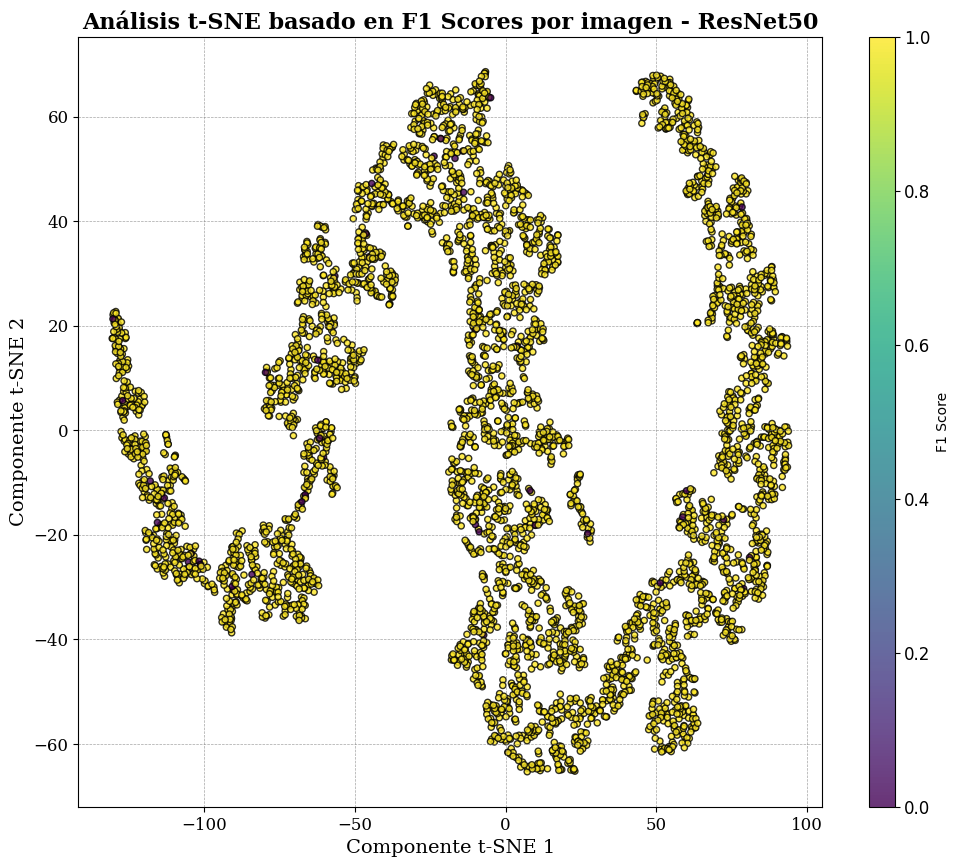

Análisis de vectores completado y guardado en 'ResNet50'.


In [ ]:
# Crear directorio para guardar resultados
os.makedirs("ResNet50", exist_ok=True)
resnet.eval()
y_true, y_pred, embeddings = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Extraer y almacenar embeddings usando avgpool y flatten
        features = resnet.avgpool(resnet.layer4(resnet.layer3(resnet.layer2(resnet.layer1(resnet.conv1(images))))))
        embeddings.append(features.view(features.size(0), -1).cpu().numpy())

# Unificar embeddings en una matriz NumPy
embeddings = np.concatenate(embeddings)

# Calcular F1 Scores por imagen
f1_scores = [f1_score([true], [pred], average='weighted') for true, pred in zip(y_true, y_pred)]

# Aplicar t-SNE con parámetros ajustados
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
embeddings_2d = tsne.fit_transform(embeddings)

# Generar el gráfico t-SNE con una paleta más profesional
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    x=embeddings_2d[:, 0], 
    y=embeddings_2d[:, 1], 
    c=f1_scores, 
    cmap='viridis',  
    s=20,             
    alpha=0.8,      
    edgecolor='k'     
)
cbar = plt.colorbar(scatter, label='F1 Score', aspect=30)
cbar.ax.tick_params(labelsize=12)

# Personalización avanzada del gráfico
plt.title('Análisis t-SNE basado en F1 Scores por imagen - ResNet50', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Componente t-SNE 1', fontsize=14, family='serif')
plt.ylabel('Componente t-SNE 2', fontsize=14, family='serif')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')

# Guardar el gráfico en formato SVG para alta calidad en presentaciones
plt.savefig("ResNet50/Vector_Analysis_ResNet50.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("ResNet50/Vector_Analysis_ResNet50.png", dpi=300, bbox_inches='tight')
plt.show()

# Guardar los datos procesados
df_embeddings = pd.DataFrame(embeddings_2d, columns=['Componente_1', 'Componente_2'])
df_embeddings['F1_Score'] = f1_scores
df_embeddings.to_csv("ResNet50/Embeddings_y_F1Scores.csv", index=False)

print("Análisis de vectores completado y guardado en 'ResNet50'.")


12. EVALUACIÓN EN EL CONJUNTO DE PRUEBA

Generando predicciones y calculando scores...


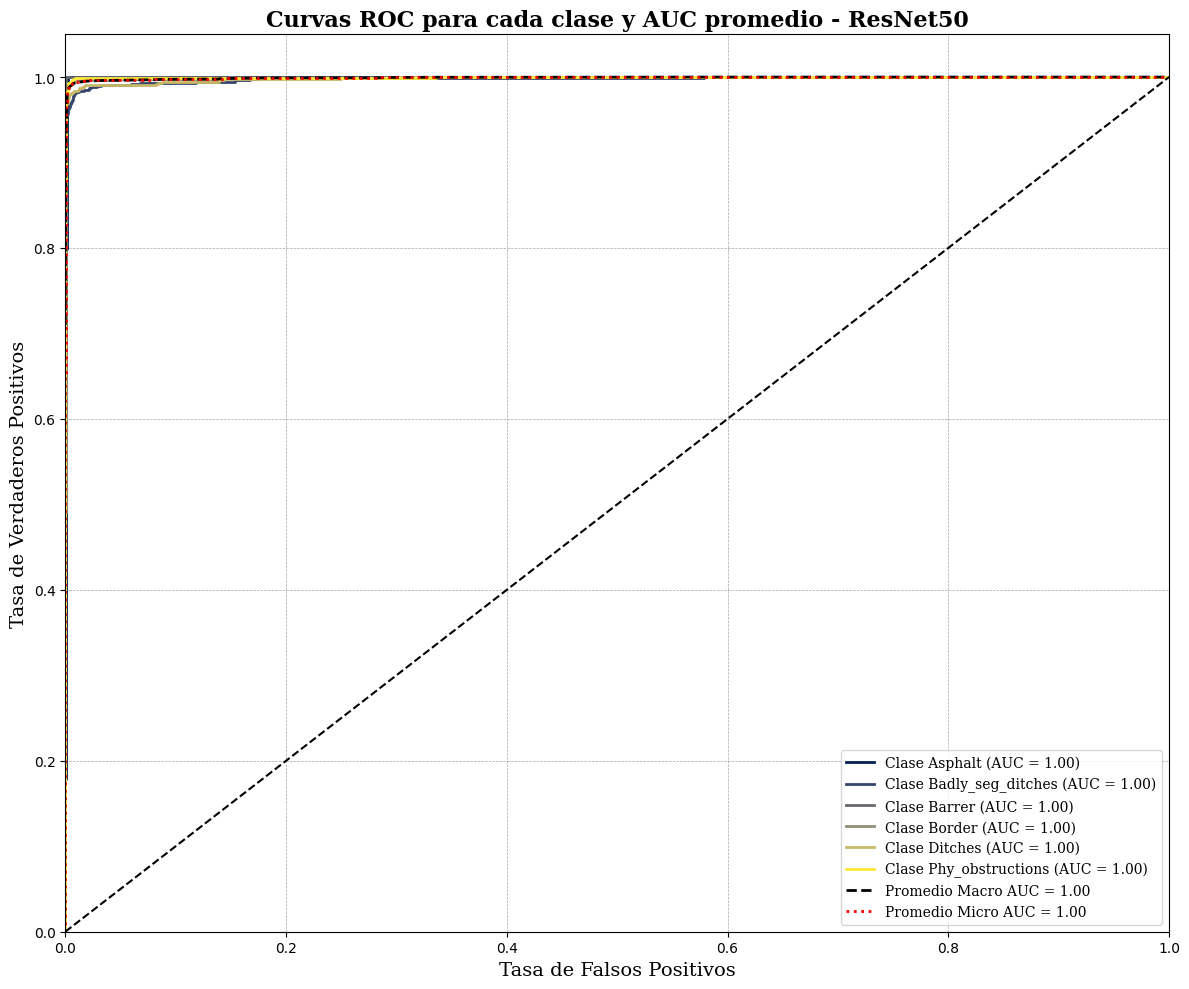

Curvas ROC generadas y guardadas en 'ResNet50'.


In [12]:
print("Generando predicciones y calculando scores...")
resnet.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_scores = np.array(y_scores)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

os.makedirs("ResNet50", exist_ok=True)

plt.figure(figsize=(12, 10))
colors = plt.cm.cividis(np.linspace(0, 1, len(class_names)))

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label=f'Clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, linestyle='--', color='black', linewidth=2,
         label=f'Promedio Macro AUC = {macro_auc:.2f}')
plt.plot(fpr_micro, tpr_micro, linestyle=':', color='red', linewidth=2,
         label=f'Promedio Micro AUC = {micro_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=14, family='serif')
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=14, family='serif')
plt.title('Curvas ROC para cada clase y AUC promedio - ResNet50', fontsize=16, fontweight='bold', family='serif')
plt.legend(loc='lower right', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("ResNet50/Curva_ROC_AUC.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("ResNet50/Curva_ROC_AUC_.png", dpi=300, bbox_inches='tight')
plt.show()

clases = class_names + ['Promedio Macro', 'Promedio Micro']
auc_scores = [roc_auc[i] for i in range(len(class_names))] + [macro_auc, micro_auc]
tipo = ['Individual'] * len(class_names) + ['Promedio Macro', 'Promedio Micro']

assert len(clases) == len(auc_scores) == len(tipo), "Las listas no tienen la misma longitud"

roc_data = {
    'Clase': clases,
    'AUC': auc_scores,
    'Tipo': tipo
}
df_roc = pd.DataFrame(roc_data)
df_roc.to_csv("ResNet50/Curvas_ROC_AUC_Resumen.csv", index=False)

print("Curvas ROC generadas y guardadas en 'ResNet50'.")


13. GUARDAR INFORME

In [13]:
# Guardar los detalles del entrenamiento en un archivo de texto
with open("ResNet50/Detalles_entrenamiento_ResNet50.txt", "w") as f:
    f.write(f"Tiempo total de entrenamiento: {training_time:.2f} segundos\n")
    f.write(f"Dispositivo: {device}\n")
    f.write("Modelo: ResNet50\n")
    f.write("Directorio del modelo: Models/ResNet50_model.pth\n")
    f.write(f"Parámetros: {sum(p.numel() for p in resnet.parameters())}\n")
    f.write("Métricas:\n")
    f.write(report_df.to_string())
    f.write("\n\nMatriz de Confusión guardada en: ResNet50/Matriz_confusion_ResNet50.png\n")
    f.write("Análisis de Vectores guardado en: ResNet50/Vector_Analysis_ResNet50.png\n")
    f.write("Curva ROC guardada en: ResNet50/Curva_ROC_AUC.png\n")
    f.write("Resumen AUC guardado en: ResNet50/Curvas_ROC_AUC_Resumen.csv\n")

print("Entrenamiento y evaluación completados. Resultados guardados en 'ResNet50'.")


Entrenamiento y evaluación completados. Resultados guardados en 'ResNet50'.
